In [452]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer
import qutip
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import array_to_latex

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

import copy
import random
import time

from qutip import *

#Supress default INFO logging. Looking at you QISKIT >:(

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import matplotlib.pyplot as plt
%matplotlib inline


In [453]:
# Will be using this backend to get matrix from circuit
backend = Aer.get_backend('unitary_simulator')

# The CCNOT Gate
We will start here by defining and showing the CCNOT gate in a basic circuit in qiskit

In [454]:
n = 3
ccnot_qc = QuantumCircuit(n)

ccnot_qc.toffoli(1,2,0)
ccnot_qc.draw()

┌───┐
q_0: ┤ X ├
     └─┬─┘
q_1: ──■──
       │  
q_2: ──■──

We can then use .get_unitary() to get the unitary for a given circuit

In [455]:
ccnot_job = execute(ccnot_qc, backend, shots=8192)
ccnot_result = ccnot_job.result()
ccnot_matrix = ccnot_result.get_unitary()
array_to_latex(ccnot_matrix)

<IPython.core.display.Latex object>

As you can see above, we get the correct matrix for a CCNOT gate. Now let's look at a different circuit, that also acts on 3 qubits, and get the matrix representation:

In [456]:
n = 3
qc2 = QuantumCircuit(n)

qc2.h(2)
qc2.cx(0,1)
qc2.draw()

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     ├───┤
q_2: ┤ H ├
     └───┘

In [457]:
job = execute(qc2, backend, shots=8192)
result = job.result()
matrix2 = result.get_unitary()
array_to_latex(matrix2)

<IPython.core.display.Latex object>

Just from looking at the matrix representation for these two 3-qubit circuits, you can see that they are very different. But how cna we quantify how different they are? A great solution to this would be to use the Hilbert Schmidt Distance:
$$d(U,V) = \sqrt{1-\frac{||Tr(U\dag V)||^{2}}{N^{2}}}$$
The Hilbert Schmidt distance is a good measure for how similar two unitaries U and V are. This is defined below:

In [484]:
# Broken down step by step to see what's going on
def hilbert_schmidt_dist(U, V, n):
    temp = U.data.conj() @ V.data
    temp = temp.trace()
    temp = np.abs(temp)
    temp = temp
    temp = temp/(2**n)**2
    temp = 1 - temp
    temp = np.sqrt(temp)
    return temp

# Pythony one line
def hsd(U,V,n):
    N=2**n
    return np.sqrt(1-np.abs((U.data.conj() @ V.data).trace())**2/N**2)

print("Hilber Schmidt distance between CCNOT and previously defined 3 qubit circuit is {}".format(hilbert_schmidt_dist(matrix2, ccnot_matrix, 3)))

Hilber Schmidt distance between CCNOT and previously defined 3 qubit circuit is 0.9519716382329886


Now let's get into the circuits that we'll be using today. In order to approximate the CCNOT gate with 2 qubit unitaries, we must first figure out how to parameterize a general 2 qubit unitary gate and 1 qubit gate. A 1 qubit gate is easier, as it's defined in the description for the u gate in qiskit:
$$U(\theta,\phi,\lambda) = \begin{pmatrix} cos(\frac{\theta}{2}) & -e^{i\lambda}sin(\frac{\theta}{2})\\ e^{i\phi}sin(\frac{\theta}{2}) & e^{i(\phi + \lambda)}cos(\frac{\theta}{2}) \end{pmatrix}$$
As you can see, a general 1 qubit unitary gate can be parameterized with 3 values. Now what about a general 2 qubit unitary? As it turns out, a 2 qubit unitary can be parameterized with 15 values. We can actually define a general 2 qubit unitary as:
$$U_{AB} = (U_{A}\otimes U_{B})U_{d}(V_{A}\otimes V_{B})$$
Which corresponds to:

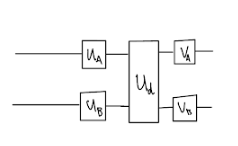

Where $U_{A}, U_{B}, V_{A}, V_{B}$ are 1 qubit unitaries and $U_{d}$ is a 2 qubit unitary. This circuit can be used to parameterize any 2 qubit unitary! Now, as we showed above, we can parameterize single qubit unitaries with 3 values, so, with our 4 single qubit unitaries, we're up to 12 parameters. But what about $U_{d}$? This can actually be parameterized with 3 values as well. We can define $U_{d}$ as:
$$U_{d}(\alpha _{1}, \alpha _{2}, \alpha _{3}) = \sum_{k=1}^4 e^{-i\lambda _{k}}\ket{\phi _{k}} \bra{\phi _{k}}$$
Where:
$$\lambda _{1} = \alpha _{1}-\alpha _{2}+\alpha _{3}$$
$$\lambda _{2} = -\alpha _{1}+\alpha _{2}+\alpha _{3}$$
$$\lambda _{3} = -\alpha _{1}-\alpha _{2}-\alpha _{3}$$
$$\lambda _{4} = \alpha _{1}+\alpha _{2}-\alpha _{3}$$
And:
$$\ket{\phi _{1}} = \ket{\Phi ^{+}}$$
$$\ket{\phi _{2}} = -i\ket{\Phi ^{-}}$$
$$\ket{\phi _{3}} = \ket{\Psi ^{-}}$$
$$\ket{\phi _{4}} = -i\ket{\Psi ^{+}}$$
Since $U_{d}$ requires another 3 parameters, we have just shown that a general 2 qubit unitary can be parameterized with 15 parameters. So how can this help us approximate CCNOT? Well, if we were to take this general 2 qubit circuit (shown in picture above), and apply it in a circuit 4 times across all qubit wires, we may be able to find proper values for these parameters that get close to CCNOT. Let's start by building this big circuit:

In [459]:
# unitary_block builds a block of gates shown in image above
# matrix_param: list of 3 parameters to build Ud
# param: list of 12 parameters to build 4 single qubit unitaries Ua, Ub, Va, and Vb
def unitary_block(circ, wires, matrix_param, param):
    matrix = build_Ud(matrix_param[0], matrix_param[1], matrix_param[2])
    circ.u(param[0], param[1], param[2], wires[0])
    circ.u(param[3], param[4], param[5], wires[1])
    circ.unitary(matrix, [wires[0], wires[1]])
    circ.u(param[6], param[7], param[8], wires[1])
    circ.u(param[9], param[10], param[11], wires[0])
    return circ.to_instruction

# builds Ud as described above
def build_Ud(x,y,z):
    b1 = qutip.bell_state('00')
    b2 = qutip.bell_state('01')
    b3 = qutip.bell_state('10')
    b4 = qutip.bell_state('11')
    
    t1 = x-y+z
    t2 = -x+y+z
    t3 = -x-y-z
    t4 = x+y-z
    
    unitary = np.exp(-1.0j*t1)*(b1*b1.dag()) +\
        np.exp(-1.0j*t2)*(b2*b2.dag()) +\
        np.exp(-1.0j*t3)*(b3*b3.dag()) +\
        np.exp(-1.0j*t4)*(b4*b4.dag())
    return unitary
    
# takes a list of 60 parameters. 15 for each block
# For the 15 for each block, first 3 are for 2 qubit unitary matrix, last 12 are for 4 single qubit rotations
def build_circuit(param):
    qc = QuantumCircuit(3)
    unitary_block(qc, [0,1], param[:3], param[3:15])
    qc.barrier()
    unitary_block(qc, [1,2], param[15:18], param[18:30])
    qc.barrier()
    unitary_block(qc, [0,2], param[30:33], param[33:45])
    qc.barrier()
    unitary_block(qc, [1,2], param[45:48], param[48:60])
    return qc
        

test_params = (np.random.uniform(0, 1, 60) * (2*np.pi - 0) + 0)
qc = build_circuit(test_params)
print("Full 60 parameter circuit using 4 blocks of generalized 2 qubit unitaries with random parameters between 2*pi and 0")
qc.draw()

Full 60 parameter circuit using 4 blocks of generalized 2 qubit unitaries with random parameters between 2*pi and 0


┌─────────────────────────┐ ┌──────────┐┌─────────────────────────┐  ░ »
q_0: ┤ U(5.3008,4.1566,2.1873) ├─┤0         ├┤ U(3.3322,3.1996,5.7033) ├──░─»
     ├─────────────────────────┴┐│  Unitary │├─────────────────────────┴┐ ░ »
q_1: ┤ U(2.4377,4.7389,0.63729) ├┤1         ├┤ U(3.0653,4.9842,0.76021) ├─░─»
     └──────────────────────────┘└──────────┘└──────────────────────────┘ ░ »
q_2: ─────────────────────────────────────────────────────────────────────░─»
                                                                          ░ »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«     ┌─────────────────────────┐ ┌──────────┐┌──────────────────────────────┐»
«q_1: ┤ U(2.3364,3.7293,1.0893) ├─┤0         ├┤ U(0.17601,0.0017237,0.86981) ├»
«     ├─────────────────────────┴┐│  Unitary │└─┬──────────────────────────┬─┘»
«q_2: ┤ U(5.3107,6.1238,0.70241) ├┤1         ├──┤ U(4.1991,2.5612,0.44713) ├──»
«     └──────────────────────────┘└──────────┘  └──────────────────────────┘  »
«      ░ ┌─────────────────────────┐┌──────────┐┌──────────────────────────┐ ░ »
«q_0: ─░─┤ U(1.3828,2.9675,0.8957) ├┤0         ├┤ U(1.2569,2.4071,0.11576) ├─░─»
«      ░ └─────────────────────────┘│          │└──────────────────────────┘ ░ »
«q_1: ─░────────────────────────────┤  Unitary ├─────────────────────────────░─»
«      ░ ┌─────────────────────────┐│          │ ┌────────────────────────┐  ░ »
«q_2: ─░─┤ U(2.1814,5.3554,3.7928) ├┤1         ├─┤ U(0.606,5.8255,4.1703) ├──░─»
«      ░ └─────────────────────────┘└──────────┘ └────────────────────────┘  ░ »
«                                                                      
«q_0: ─────────────────────────────────────────────────────────────────
«      ┌────────────────────────┐┌──────────┐┌────────────────────────┐
«q_1: ─┤ U(3.3455,6.2188,6.232) ├┤0         ├┤ U(1.497,4.3458,3.7192) ├
«     ┌┴────────────────────────┤│  Unitary │├───────────────────────┬┘
«q_2: ┤ U(3.9039,4.4011,1.0374) ├┤1         ├┤ U(5.353,3.7395,5.783) ├─
«     └─────────────────────────┘└──────────┘└───────────────────────┘

Now let's take a look at the matrix that this circuit creates:

In [460]:
qc_job = execute(qc, backend, shots=8192)
qc_result = qc_job.result()
qc_matrix = qc_result.get_unitary()
array_to_latex(qc_matrix)

<IPython.core.display.Latex object>

Oof, that's hard to look at. For fun, how about we calculate the Hilbert-Schmidt distance between these random parameters and CCNOT:

In [461]:
print("Hilbert Schmidt distance between randomized parameter circuit and CCNOT is {}".format(hsd(qc_matrix, ccnot_matrix, 3)))

Hilbert Schmidt distance between randomized parameter circuit and CCNOT is 0.9941663926056596


Hmm well that's not good. How can we make this better? Well, we can try to use optimization algorithms to get a better set of parameters. To do this, we need to start with a loss function. In this case, we'll build the circuit with a list of 60 parameters, then calculate the Hilbert-Schmidt distance of this circuit and CCNOT to get the loss. This loss will then be used by our algorithm to find a better set of parameters, and so on. For the loss function, we can use:

In [462]:
# takes a list of 60 parameters. 15 for each block
# For the 15 for each block, first 3 are for 2 qubit unitary matrix, last 12 are for 4 single qubit rotations
def get_loss(param):
    qc = build_circuit(param)
    job = execute(qc, backend, shots=8192)
    result = job.result()
    matrix = result.get_unitary()
    return hsd(matrix, ccnot_matrix, 3)
    
def get_swarm_loss(param):
    ret = np.zeros(len(param))
    for i in range(len(param)):
        qc = build_circuit(param[i])
        job = execute(qc, backend, shots=8192)
        result = job.result()
        matrix = result.get_unitary()
        ret[i] = hsd(matrix, ccnot_matrix, 3)
    return ret

Now let's think about the optimization algorithm that we want to use. Personally, I'm enamored with "natural" optimization algorithms, or optimizatoin algorithms that are based on occurences in nature. So I'll start with one of those. It just so happens that there is an algorithm that has been developed after the hunting patterns of my favorite animal, the Grey Wolf. The Grey Wolf optimization algorithm was first proposed in 2014 by Seyedali Mirjalili. You can find the original paper here:
https://img1.wsimg.com/blobby/go/e8abc963-7b19-40d6-a270-eed55d317dba/GWO_finalVersion.pdf
Basically, the algorithm is meant to mimmick the way that a pack of wolves hunts it's prey. It is part of a class of optimization algorithms known as swarm intelligence optimization, which, at their most basic, create "searchers" are random places within the search space of the function you are optimizing, and "move" these searchers until they find a good answer. Here, the searchers are meant to be a wolf pack, and the way they move is meant to mimmick the hunting patterns of said wolf pack. I wanted to have some fun with programming something, so let's write it from scratch (with some help from the author) below! Oh, I also added a survival of the fittest upgrade to the algorithm found in this paper: https://www.nature.com/articles/s41598-019-43546-3. I couldn't get all of their upgrades to work in time, but it's defintely better with the survival of the fittest component. This basically just eliminates the worst R number of wolves and replaces them with new randomized wolves every iteration. Helps with getting stuck in local minimums.

In [463]:
# this class will hold all the important information that we want from the optimization algorithm
class GreyWolfOptimizerOutput:
    def __init__(self, start_time):
        self._start_time = start_time
    
    def set_end(self, end_time):
        self._end_time = end_time
        
    def set_curve(self, converge):
        self._converge_curve = converge
        
    def set_total_time(self, total):
        self._time_take = total
        
    def set_params(self, params):
        self._best_params = params
        
    def set_fitness(self, fitness):
        self._best_fitness = fitness
        
    def set_opt_params(self, count, iter, upper, lower, remove):
        self._wolf_count = count
        self._iterations = iter
        self._upper = upper
        self._lower = lower
        self._remove = remove

# obj_func: objective function (also called fitness function) that you are using to optimize
# max_iterations: number of optimization loops run
# wolf_count: number of searchers/nodes/particles 
# dimensions: number of parameters you are optimizing for
# upper_bound: upper bound on parameter value
# lower_bound: lower bound on parameter value
# remove: number of wolves that die and get replaced every iteration (maybe not every, still messing with optimal implementation)
def GreyWolfOptimizer(obj_func, max_iterations, wolf_count, dimensions, upper_bound, lower_bound, remove):
     # Alrighty then, let's start by initializing the Alpha, Beta, and Delta wolves info
    Alpha_pos = np.zeros(dimensions)
    Alpha_score = float("inf")

    Beta_pos = np.zeros(dimensions)
    Beta_score = float("inf")

    Delta_pos = np.zeros(dimensions)
    Delta_score = float("inf")

    # Now let's build our pack, or "search agents" if you're a nerd.
    # This will be an array of random parameters for each wolf. So it'll be wolf_count x dimensions in size
    Positions = np.zeros((wolf_count, dimensions))
    for i in range(dimensions):
        Positions[:, i] = (np.random.uniform(0, 1, wolf_count) * (upper_bound - lower_bound) + lower_bound) # rand init within bound
        
    # For graphing later
    Convergence_curve = np.zeros(max_iterations)

    # Initialize class that holds info and start the clock!
    out = GreyWolfOptimizerOutput(time.strftime("%Y-%m-%d-%H-%M-%S"))
    timerStart = time.time()
    # Main loop
    for l in range(0, max_iterations):
        # remove_list holds position of wolves with the worst (highest) fitness score
        # They will die in this harsh winter, but will be replaced by new pups
        # worst wolf is at front (0), tuple order is [position][fitness]
        remove_list = [[0.0, 0.0] for _ in range(remove)]
        for i in range(0, wolf_count):

            # Return back the wolves that go beyond the boundaries of the search space
            for j in range(dimensions):
                Positions[i, j] = np.clip(Positions[i, j], lower_bound, upper_bound)

            # Calculate objective/fitness function for each wolf
            fitness = obj_func(Positions[i, :])

            # Update Alpha, Beta, and Delta
            # This is their implentation. I don't like this. Might fix later
            # Is it faster to sort to find best and worst every loop? Hmmmmmm
            if fitness < Alpha_score:
                Delta_score = Beta_score 
                Delta_pos = Beta_pos.copy()
                Beta_score = Alpha_score
                Beta_pos = Alpha_pos.copy()
                Alpha_score = fitness
                Alpha_pos = Positions[i, :].copy()

            if fitness > Alpha_score and fitness < Beta_score:
                Delta_score = Beta_score
                Delta_pos = Beta_pos.copy()
                Beta_score = fitness
                Beta_pos = Positions[i, :].copy()

            if fitness > Alpha_score and fitness > Beta_score and fitness < Delta_score:
                Delta_score = fitness
                Delta_pos = Positions[i, :].copy()
                
            # SURVIVAL OF THE FITTEST
            # Find out if wolf is one of the worst, if so, add it to list and pop best on list
            # RIP wolves
            for j in range(remove):
                if fitness > remove_list[j][1]:
                    remove_list.insert(j, [i, fitness])
                    del remove_list[-1]
                    break
            
        # New wolves in the pack
        # Initialize new wolves with random values
        for r in remove_list:
            Positions[r[0]] = (np.random.uniform(0, 1, dimensions) * (upper_bound - lower_bound) + lower_bound)
            
        # Used for updating, scales from 2 to 0 as the function and hunt progress
        a = 2 - l * ((2) / max_iterations)

        # Update the Position of the wolves
        # I don't think it's super important to go into vivid detail about why/how the updating process works. 
        # But feel free to check out the paper. They got some pretty good results.
        for i in range(0, wolf_count):
            for j in range(0, dimensions):

                r1 = random.random()  # r1 is a random number in [0,1]
                r2 = random.random()  # r2 is a random number in [0,1]

                A1 = 2 * a * r1 - a
                C1 = 2 * r2

                D_alpha = abs(C1 * Alpha_pos[j] - Positions[i, j])
                X1 = Alpha_pos[j] - A1 * D_alpha

                r1 = random.random()
                r2 = random.random()

                A2 = 2 * a * r1 - a
                C2 = 2 * r2

                D_beta = abs(C2 * Beta_pos[j] - Positions[i, j])
                X2 = Beta_pos[j] - A2 * D_beta

                r1 = random.random()
                r2 = random.random()

                A3 = 2 * a * r1 - a
                C3 = 2 * r2

                D_delta = abs(C3 * Delta_pos[j] - Positions[i, j])
                X3 = Delta_pos[j] - A3 * D_delta

                Positions[i, j] = (X1 + X2 + X3) / 3

        Convergence_curve[l] = Alpha_score
        print(["At iteration " + str(l) + " the best fitness is " + str(Alpha_score)])

    # Get all useful information before finishing funciton
    timerEnd = time.time()
    out.set_params(Alpha_pos)
    out.set_curve(Convergence_curve)
    out.set_end(time.strftime("%Y-%m-%d-%H-%M-%S"))
    out.set_fitness(Alpha_score)
    out.set_total_time(timerEnd - timerStart)
    out.set_opt_params(wolf_count, max_iterations, upper_bound, lower_bound, remove)

    return out

60 parameters really is a lot to optimize though, so let's try to get that number down. Fortuntely, some of the gates in our original naive implementation cancel out, and we can actually get the number of parameters down to 45 with the following circuit!

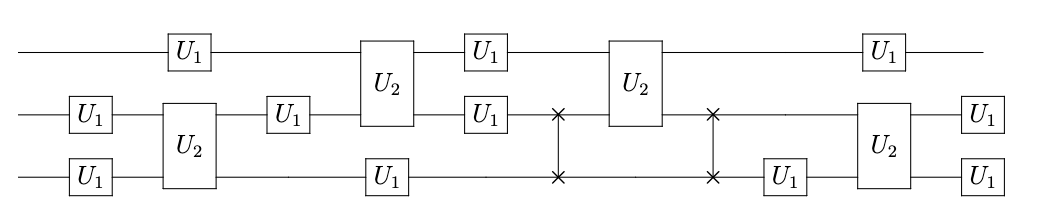

Implementation:

In [464]:
# takes a list of 60 parameters. 15 for each block
# For the 15 for each block, first 3 are for 2 qubit unitary matrix, last 12 are for 4 single qubit rotations
def build_circuit2(params):
    qc = QuantumCircuit(3)
    qc.u(params[0], params[1], params[2], 0)
    qc.u(params[3], params[4], params[5], 1)
    qc.u(params[6], params[7], params[8], 2)
    matrix = build_Ud(params[9], params[10], params[11])
    qc.unitary(matrix, [1,2])
    qc.u(params[12], params[13], params[14], 1)
    matrix = build_Ud(params[15], params[16], params[17])
    qc.unitary(matrix, [0,1])
    qc.u(params[18], params[19], params[20], 2)
    qc.u(params[21], params[22], params[23], 1)
    qc.u(params[24], params[25], params[26], 0)
    matrix = build_Ud(params[27], params[28], params[29])
    qc.unitary(matrix, [0,2])
    qc.u(params[30], params[31], params[32], 0)
    qc.u(params[33], params[34], params[35], 2)
    matrix = build_Ud(params[36], params[37], params[38])
    qc.unitary(matrix, [1,2])
    qc.u(params[39], params[40], params[41], 1)
    qc.u(params[42], params[43], params[44], 2)
    return qc
    
def get_loss2(param):
    qc = build_circuit2(param)
    job = execute(qc, backend, shots=8192)
    result = job.result()
    matrix = result.get_unitary()
    return hsd(matrix, ccnot_matrix, 3)
    
def get_swarm_loss2(param):
    ret = np.zeros(len(param))
    for i in range(len(param)):
        qc = build_circuit2(param[i])
        job = execute(qc, backend, shots=8192)
        result = job.result()
        matrix = result.get_unitary()
        ret[i] = hsd(matrix, ccnot_matrix, 3)
    return ret
        

#test_params = [np.pi for x in range(60)]
test_params = (np.random.uniform(0, 1, 45) * (2*np.pi - 0) + 0)
l = get_loss2(test_params)
print(l)
qc = build_circuit2(test_params)
qc.draw()

0.9904572465869768


┌──────────────────────────┐                                       »
q_0: ┤ U(1.8633,3.6101,0.33406) ├───────────────────────────────────────»
     ├──────────────────────────┤┌──────────┐┌─────────────────────────┐»
q_1: ┤ U(4.9311,0.41775,5.9517) ├┤0         ├┤ U(5.2607,3.6112,4.6256) ├»
     ├─────────────────────────┬┘│  Unitary │├─────────────────────────┤»
q_2: ┤ U(4.8592,5.6206,3.1684) ├─┤1         ├┤ U(6.1924,1.1208,2.9897) ├»
     └─────────────────────────┘ └──────────┘└─────────────────────────┘»
«     ┌──────────┐ ┌────────────────────────┐ ┌──────────┐»
«q_0: ┤0         ├─┤ U(2.6009,2.6629,5.378) ├─┤0         ├»
«     │  Unitary │┌┴────────────────────────┴┐│          │»
«q_1: ┤1         ├┤ U(2.7028,4.6391,0.81682) ├┤  Unitary ├»
«     └──────────┘└──────────────────────────┘│          │»
«q_2: ────────────────────────────────────────┤1         ├»
«                                             └──────────┘»
«     ┌────────────────────────────┐                                        
«q_0: ┤ U(1.3661,0.0082659,2.5559) ├────────────────────────────────────────
«     └────────────────────────────┘┌──────────┐┌─────────────────────────┐ 
«q_1: ──────────────────────────────┤0         ├┤ U(5.1741,2.7521,3.6571) ├─
«      ┌─────────────────────────┐  │  Unitary │├─────────────────────────┴┐
«q_2: ─┤ U(1.6296,5.6291,0.4205) ├──┤1         ├┤ U(0.17758,4.6299,5.1266) ├
«      └─────────────────────────┘  └──────────┘└──────────────────────────┘

This is much more managable. Unfortunetly though, I ran into another road block with this implementation: using qiskit to build the circuit everytime to get the matrix for the loss function is a lot of computational overhead that we don't need. We can instead build the circuit in qutip to eliminate this issue. We'll use the new 45 parameter circuit this time, and build the unitaries just like we did before:

In [ ]:
phi_p = 1/np.sqrt(2)*((tensor(basis(2,0),basis(2,0)) + tensor(basis(2,1),basis(2,1))))
phi_m = 1/np.sqrt(2)*((tensor(basis(2,0),basis(2,0)) - tensor(basis(2,1),basis(2,1))))
psi_p = 1/np.sqrt(2)*((tensor(basis(2,0),basis(2,1)) + tensor(basis(2,1),basis(2,0))))
psi_m = 1/np.sqrt(2)*((tensor(basis(2,0),basis(2,1)) - tensor(basis(2,1),basis(2,0))))


def d1(x, y, z):
    ket = phi_p
    bra = ket.dag()
    lam = x - y + z 
    return np.exp(-1.0j*lam)*ket*bra

def d2(x, y, z):
    ket = -1.0j*phi_m
    bra = ket.dag()
    lam = -x + y + z 
    return np.exp(-1.0j*lam)*ket*bra
    
def d3(x, y, z):
    ket = psi_m
    bra = ket.dag()
    lam = -x - y - z 
    return np.exp(-1.0j*lam)*ket*bra    

def d4(x, y, z):
    ket = -1.0j*psi_p
    bra = ket.dag()
    lam = x + y - z 
    return np.exp(-1.0j*lam)*ket*bra    
    
    
def u2(theta,phi,alpha):
    return d1(theta,phi,alpha)+d2(theta,phi,alpha)+d3(theta,phi,alpha)+d4(theta,phi,alpha)

def u1(theta,phi,lam):
    a = np.cos(theta/2) * (basis(2,0)*basis(2,0).dag())
    b = -np.exp(1.0j*lam)*np.sin(theta/2) * (basis(2,0)*basis(2,1).dag())
    c = np.exp(1.0j*phi)*np.sin(theta/2) *(basis(2,1)*basis(2,0).dag())
    d = np.exp(1.0j*(phi+lam))*np.cos(theta/2)*(basis(2,1)*basis(2,1).dag())
    return a+b+c+d

print(u1(np.pi, 2, 3))
SWAP = tensor(qeye(2),(tensor(ket('0')*bra('0'),ket('0')*bra('0'))+tensor(ket('1')*bra('1'),ket('1')*bra('1'))+tensor(ket('1')*bra('0'),ket('0')*bra('1'))+tensor(ket('0')*bra('1'),ket('1')*bra('0'))))
CCNOT = tensor(ket('0')*bra('0'),ket('0')*bra('0'),qeye(2))+tensor(ket('1')*bra('1'),ket('0')*bra('0'),qeye(2))+tensor(ket('0')*bra('0'),ket('1')*bra('1'),qeye(2))+tensor(ket('1')*bra('1'),ket('1')*bra('1'),sigmax())


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.        +0.j          0.9899925 -0.14112001j]
 [-0.41614684+0.90929743j  0.        +0.j        ]]


In [ ]:
def qutip_circ(params):
    # u1 gates on 0,1,2
    l1 = tensor(u1(params[0], params[1], params[2]), u1(params[3], params[4], params[5]), u1(params[6], params[7], params[8]))
    # u2 gate on 1,2
    l2 = tensor(qeye(2), u2(params[9], params[10], params[11]))
    # u1 gates on 1,2
    l3 = tensor(qeye(2), u1(params[12], params[13], params[14]), u1(params[15], params[16], params[17]))
    # u2 gate on 0,1
    l4 = tensor(u2(params[18], params[19], params[20]), qeye(2))
    # u1 gates on 0,1
    l5 = tensor(u1(params[21], params[22], params[23]), u1(params[24], params[25], params[26]), qeye(2))
    # SWAP on 1,2
    l6 = SWAP
    # u2 gate on 0,1
    l7 = tensor(u2(params[27], params[28], params[29]), qeye(2))
    # SWAP on 1,2
    l8 = SWAP
    # u1 gates on 0,2
    l9 = tensor(u1(params[30], params[31], params[32]), qeye(2), u1(params[33], params[34], params[35]))
    # u2 gate on 1,2
    l10 = tensor(qeye(2), u2(params[36], params[37], params[38]))
    # u1 gates on 1,2
    l11 = tensor(qeye(2), u1(params[39], params[40], params[41]), u1(params[42], params[43], params[44]))
    return l11*l10*l9*l8*l7*l6*l5*l4*l3*l2*l1

# without the visualization tools, it's hard to tell which circuit is correct. but it's this one
def qutip_circ2(params):
    l1 = tensor(u1(params[8],params[7],params[6]),u1(params[5],params[4],params[3]),u1(params[2],params[1],params[0]))
    l2 = tensor(u2(params[11],params[10],params[9]),qeye(2))
    l3 = tensor(qeye(2),u1(params[14],params[13],params[12]),qeye(2))
    l4 = tensor(u1(params[20],params[19],params[18]),u2(params[17],params[16],params[15]))
    l5 = tensor(qeye(2),u1(params[23],params[22],params[21]),qeye(2))
    l6 = tensor(u2(params[26],params[25],params[24]),qeye(2))
    l7 = tensor(u1(params[35],params[34],params[33]),u1(params[32],params[31],params[30]),u1(params[29],params[28],params[27]))
    l8 = SWAP
    l9 = tensor(u2(params[38],params[37],params[36]),qeye(2))
    l10 = SWAP
    l11 = tensor(u1(params[44],params[43],params[42]),qeye(2),u1(params[41],params[40],params[39]))
    return l11*l10*l9*l8*l7*l6*l5*l4*l3*l2*l1
    

params = np.ones(45)
print(qutip_circ(params).full())
print(qutip_circ2(params).full())

[[ 5.19988583e-04+0.93794633j  4.08651967e-03+0.01383883j
   1.17621197e-01-0.21428475j -9.62107625e-02+0.03991677j
   7.54889589e-02-0.18472519j -7.33003025e-02-0.03274164j
  -2.80495631e-02+0.04802717j  9.15446697e-03-0.00123168j]
 [-1.17621197e-01+0.21428475j  1.13839039e-01-0.17294745j
  -7.67788641e-02+0.04934203j  1.25420281e-01-0.03533967j
  -5.72406445e-01+0.61126341j -9.31467886e-02+0.23836294j
   3.09068041e-01+0.01011898j -7.70946224e-02-0.06094293j]
 [-4.08651967e-03-0.01383883j  1.12939742e-01+0.92966871j
   1.13839039e-01-0.17294745j  6.42087250e-02+0.07440977j
  -1.41157677e-02+0.16146099j  6.02512590e-02+0.14951862j
   8.15994443e-02-0.09951008j -3.18438831e-02+0.01982588j]
 [-9.62107625e-02+0.03991677j -6.42087250e-02-0.07440977j
  -1.25420281e-01+0.03533967j -1.04300537e-01-0.05542045j
  -1.68859822e-01-0.3544903j   4.95939529e-01+0.63443091j
   1.33770182e-02-0.35369556j  3.57006074e-02+0.13918248j]
 [-7.54889589e-02+0.18472519j -1.41157677e-02+0.16146099j
  -5.72406

This way is a lot less readable in my opinion, hence why I started with qiskit. But we now have the unitaries up and running, so lets define a new loss function.

In [ ]:
def hsd_qutip(U, V, n):
    N = 2**n
    temp = (np.abs(Qobj.tr(U.dag()*V))**2/(N)**2)
    temp = 1-temp
    return np.sqrt(temp)

def get_loss_qutip(params):
    return hsd_qutip(qutip_circ2(params), CCNOT, 3)

def get_loss_qutip_swarm(params):
    ret = np.zeros(len(params))
    for i in range(len(params)):
        ret[i] = hsd_qutip(qutip_circ2(params[i]), CCNOT, 3)
    return ret

#print(hsd_qutip(SWAP, CCNOT, 3))
t_params = np.ones(45)
#print(get_loss_qutip(t_params))
t_params_swarm = np.ones((10, 45))
#print(get_loss_qutip_swarm(t_params_swarm))

Positions = np.zeros((10, 45))
for i in range(10):
    Positions[i] = (np.random.uniform(0, 1, 45) * (2*np.pi - 0) + 0)
#print(Positions)
#print(hsd_qutip(qutip_circ(Positions), CCNOT, 3))
print(get_loss_qutip_swarm(Positions))

[0.99710371 0.99490066 0.98228482 0.99733788 0.99640979 0.98916981
 0.99338886 0.99649829 0.99489506 0.99736599]


And now we can use this loss function with optimization algorithms to find the best set of parameters to approximate the CCNOT gate. We'll start with swarm optimization, and then try the grey wolf algorithm:

In [ ]:
particle_swarm_runs_qutip = []

In [ ]:
#use particle swarm
# Set-up hyperparameters
options = {'c1':0.5, 'c2':0.9, 'w':0.9}

#bounds (min, max)
bounds = (0 * np.ones(45), 2*np.pi * np.ones(45))

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=250, dimensions=45, options=options, bounds = bounds)

# Perform optimization
logger.setLevel(logging.CRITICAL)
start = time.time()
best_fitness, best_param = optimizer.optimize(get_loss_qutip_swarm, iters=1000)
end = time.time()
particle_swarm_runs_qutip.append([optimizer, start-end])

pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.838


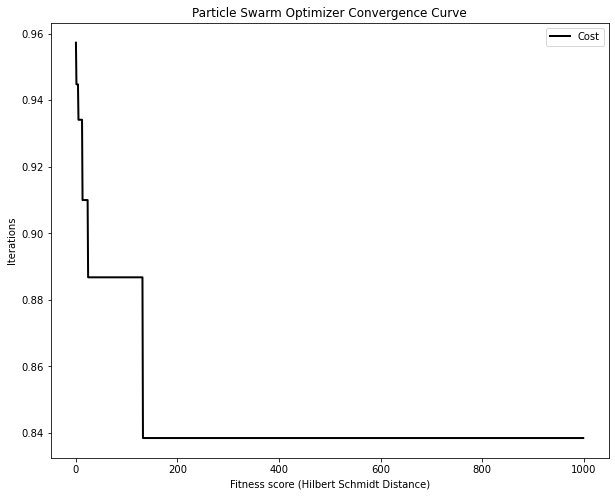

In [ ]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.xlabel("Fitness score (Hilbert Schmidt Distance)")
plt.ylabel("Iterations")
plt.title("Particle Swarm Optimizer Convergence Curve")
plt.show()

In [ ]:
grey_wolf_runs_qutip = []

In [ ]:
gwo = GreyWolfOptimizer(obj_func=get_loss_qutip, max_iterations=200, wolf_count=100, dimensions=45, upper_bound=2*np.pi, lower_bound=0, remove=20)
grey_wolf_runs_qutip.append(gwo)


['At iteration 0 the best fitness is 0.9568353713780685']
['At iteration 1 the best fitness is 0.9568353713780685']
['At iteration 2 the best fitness is 0.9568353713780685']
['At iteration 3 the best fitness is 0.9568353713780685']
['At iteration 4 the best fitness is 0.9568353713780685']
['At iteration 5 the best fitness is 0.9568353713780685']
['At iteration 6 the best fitness is 0.9568353713780685']
['At iteration 7 the best fitness is 0.9568353713780685']
['At iteration 8 the best fitness is 0.9568353713780685']
['At iteration 9 the best fitness is 0.9568353713780685']
['At iteration 10 the best fitness is 0.9568353713780685']
['At iteration 11 the best fitness is 0.9568353713780685']
['At iteration 12 the best fitness is 0.9568353713780685']
['At iteration 13 the best fitness is 0.9568353713780685']
['At iteration 14 the best fitness is 0.9568353713780685']
['At iteration 15 the best fitness is 0.9568353713780685']
['At iteration 16 the best fitness is 0.9568353713780685']
['At it

[]

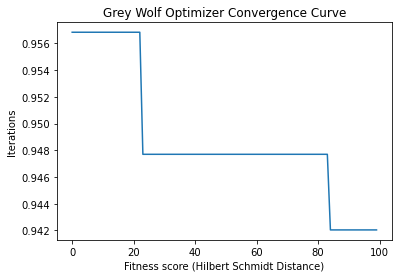

In [ ]:
print("With {} wolves, {} iterations, removing {} each iteration. It took {} minutes to get a final Hilbert-Schmidt distance of {}".format(gwo._wolf_count, gwo._iterations, gwo._remove, gwo._time_take/60, gwo._best_fitness))
plt.plot(gwo._converge_curve)
plt.xlabel("Fitness score (Hilbert Schmidt Distance)")
plt.ylabel("Iterations")
plt.title("Grey Wolf Optimizer Convergence Curve")
plt.plot()

Here's another run from earlier that I lost the data to:

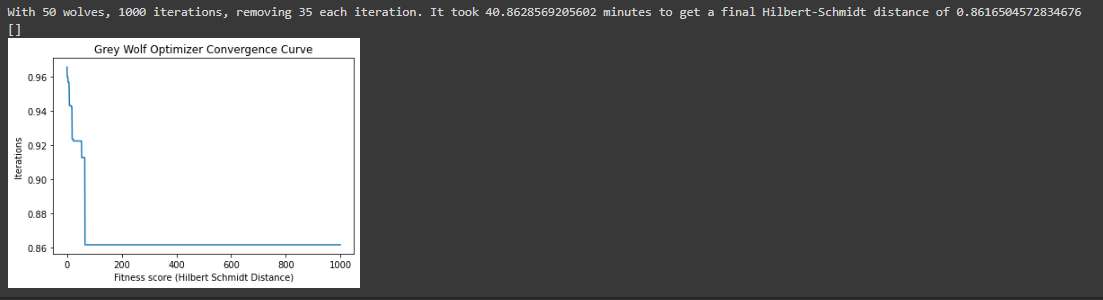

As you can see, these runs all seem to get stuck in local minimums in the 0.9ish range. This is not a very good result, as just the identity will give you a Hilbert Schmidt distance of 0.66. So what did we learn from this? 1) This is a tough problem for optimization, and 2) I wasted a lot of time running all of these to 1000 iterations. There seems to be some local minimums that are destroying the algorithms. Particle swarm and grey wolf unfortunately both are known for not having the best exploration abilities, and are more focused on exploitation. If I had more time, I'd probably write a custom artificial bee colony/particle swarm optimization algorithm for this problem, as that seems to be what researchers are finding works well with high-dimensional optimization problems. Artificial bee colony algorithms have great exploration. But this isn't an optimization class, so let's try this another way. Let's take the decomposition of the CCNOT gate found in Nielson and Chuang:

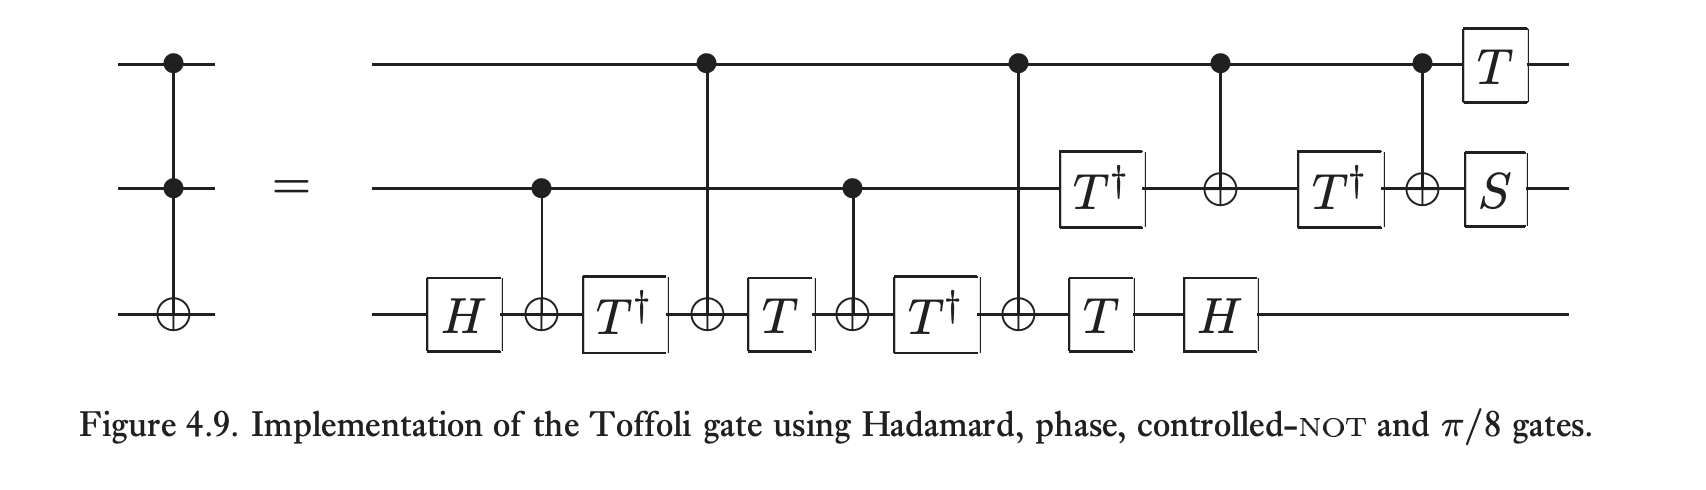

And let's play around with it. How about we start by removing the top right portion, so that we're left with only 4 CNOT's:

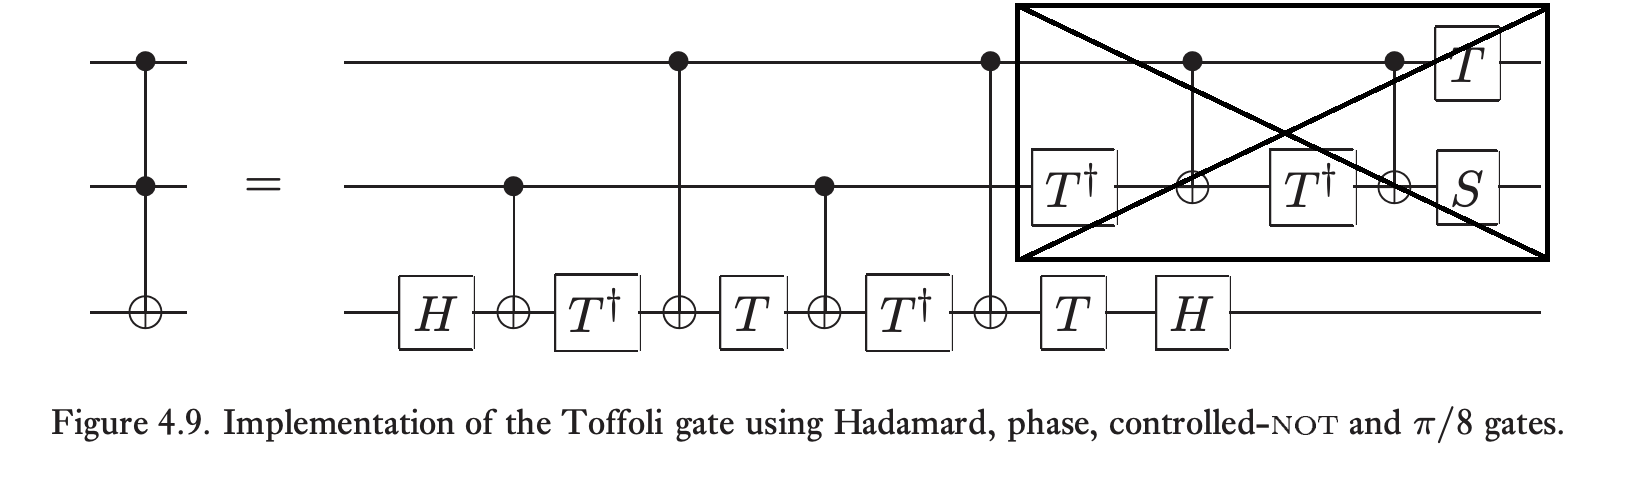

In [481]:
partial_qc = QuantumCircuit(3)
partial_qc.h(0)
partial_qc.cnot(1,0)
partial_qc.tdg(0)
partial_qc.cnot(2,0)
partial_qc.t(0)
partial_qc.cnot(1,0)
partial_qc.tdg(0)
partial_qc.cnot(2,0)
partial_qc.t(0)
partial_qc.h(0)

partial_qc.draw()


┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ H ├
     └───┘└─┬─┘└─────┘└─┬─┘└───┘└─┬─┘└─────┘└─┬─┘└───┘└───┘
q_1: ───────■───────────┼─────────■───────────┼────────────
                        │                     │            
q_2: ───────────────────■─────────────────────■────────────

There you can see it implemented in qiskit without the upper right (lower right in qiskit) block. How about we see what the Hilbert Schmidt distance is for this:

In [482]:
partial_qc_job = execute(partial_qc, backend, shots=8192)
partial_qc_result = partial_qc_job.result()
partial_qc_matrix = partial_qc_result.get_unitary()
array_to_latex(partial_qc_matrix)

<IPython.core.display.Latex object>

In [510]:
print("Hilbert Schmidt Distance for abbreviated CCNOT circuit is {}".format(hsd(partial_qc_matrix, ccnot_matrix, 3)))

Hilbert Schmidt Distance for abbreviated CCNOT circuit is 0.6123724356957945


... Welp that's better than I got before, for so much less work. Moral of the story, don't overcomplicate things. On that note, let's complicate things again. What if we replaced the block that we removed with 2 parameterizable single qubit unitaries, and then optimized just those 6 parameters? Let's find out!

In [489]:
# New loss function for new abbreviated CCNOT circuit with 2 parameterized single qubit gates at the end
def get_loss_easy(params):
    new_qc = QuantumCircuit(3)
    new_qc.h(0)
    new_qc.cnot(1,0)
    new_qc.tdg(0)
    new_qc.cnot(2,0)
    new_qc.t(0)
    new_qc.cnot(1,0)
    new_qc.tdg(0)
    new_qc.cnot(2,0)
    new_qc.t(0)
    new_qc.h(0)
    new_qc.u(params[0], params[1], params[2], 1)
    new_qc.u(params[3], params[4], params[5], 2)
    job = execute(new_qc, backend, shots=8192)
    result = job.result()
    mat = result.get_unitary()
    return hsd(mat, ccnot_matrix, 3)


In [490]:
gwo_easy = []

In [508]:
for i in range(5):
    gwo = GreyWolfOptimizer(get_loss_easy, 100, 10, 6, 2*np.pi, 0, i)
    gwo_easy.append(gwo)

['At iteration 0 the best fitness is 0.8974166423727983']
['At iteration 1 the best fitness is 0.5603989022473984']
['At iteration 2 the best fitness is 0.5603989022473984']
['At iteration 3 the best fitness is 0.5603989022473984']
['At iteration 4 the best fitness is 0.5603989022473984']
['At iteration 5 the best fitness is 0.5603989022473984']
['At iteration 6 the best fitness is 0.4297720521027396']
['At iteration 7 the best fitness is 0.40281137520364607']
['At iteration 8 the best fitness is 0.40281137520364607']
['At iteration 9 the best fitness is 0.40281137520364607']
['At iteration 10 the best fitness is 0.40281137520364607']
['At iteration 11 the best fitness is 0.40281137520364607']
['At iteration 12 the best fitness is 0.40281137520364607']
['At iteration 13 the best fitness is 0.40281137520364607']
['At iteration 14 the best fitness is 0.40281137520364607']
['At iteration 15 the best fitness is 0.40281137520364607']
['At iteration 16 the best fitness is 0.40281137520364607

In [511]:
best_hsd = 1
best_params = []
for gwo in gwo_easy:
    print("With {} wolves, {} iterations, removing {} each iteration. It took {} minutes to get a final Hilbert-Schmidt distance of {}".format(gwo._wolf_count, gwo._iterations, gwo._remove, gwo._time_take/60, gwo._best_fitness))
    if gwo._best_fitness < best_hsd:
        best_hsd = gwo._best_fitness
        best_params = gwo._best_params
    

With 20 wolves, 100 iterations, removing 4 each iteration. It took 0.8778865377108256 minutes to get a final Hilbert-Schmidt distance of 0.3826930882496907
With 30 wolves, 100 iterations, removing 10 each iteration. It took 1.317774200439453 minutes to get a final Hilbert-Schmidt distance of 0.3827402385696495
With 10 wolves, 100 iterations, removing 2 each iteration. It took 0.4251698970794678 minutes to get a final Hilbert-Schmidt distance of 0.3833565949111643
With 20 wolves, 100 iterations, removing 6 each iteration. It took 0.8519065101941427 minutes to get a final Hilbert-Schmidt distance of 0.3828730895744155
With 20 wolves, 100 iterations, removing 4 each iteration. It took 0.8348838607470195 minutes to get a final Hilbert-Schmidt distance of 0.382800549183523
With 20 wolves, 100 iterations, removing 4 each iteration. It took 0.9587626139322917 minutes to get a final Hilbert-Schmidt distance of 0.3827148191105569
With 20 wolves, 100 iterations, removing 4 each iteration. It too

In [515]:
print("\n\nThe best Hilber Schmidt Distance I could get with this method is {}. I maybe could get better with some changes, but I don't have time to make them right now :(".format(best_hsd))
print("Now let's look at the matrix using the best parameters found:")
best_qc = QuantumCircuit(3)
best_qc.h(0)
best_qc.cnot(1,0)
best_qc.tdg(0)
best_qc.cnot(2,0)
best_qc.t(0)
best_qc.cnot(1,0)
best_qc.tdg(0)
best_qc.cnot(2,0)
best_qc.t(0)
best_qc.h(0)
best_qc.u(best_params[0], best_params[1], best_params[2], 1)
best_qc.u(best_params[3], best_params[4], best_params[5], 2)
job = execute(best_qc, backend, shots=8192)
result = job.result()
best_mat = result.get_unitary(best_qc, 3)
array_to_latex(best_mat)



The best Hilber Schmidt Distance I could get with this method is 0.38268366340941984. I maybe could get better with some changes, but I don't have time to make them right now :(
Now let's look at the matrix using the best parameters found:


<IPython.core.display.Latex object>

In [516]:
print(best_params)

[5.86061043e-04 7.56855445e-01 2.78976235e-02 6.28307953e+00
 6.28318531e+00 7.85157557e-01]


Final thoughts: I feel like an important take away from this is that the best answer involved combining "physics" (just reasoning out a better solution rather than brute forcing optimization) and "computer science" (brute forcing optimization). I spent probably a grand total of 20+ hours just on the original 45 parameter optimizing part, expecting it to work if I tried hard enough. That was a huge mistake, I wish I had started from the "physics" approach, because that took me like an hour to set up (though I ran the optimization for a while).
Also, most importantly, MY WOLF OPTIMIZER WORKED SO WELL!!!!!!!